# Tune_lgb
* 이전결과 : 0.3913216698(n_estimator 1000까지)/ 0.404706925(early_stopping까지)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss


import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV, GridSearchCV

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# #colab용
# import os
# os.chdir('/content/drive/My Drive/Colab Notebooks/Dacon/천체관측/')

In [4]:
path = "./data/"
train_df = pd.read_csv(path+'train.csv',index_col=0)
test_df = pd.read_csv(path+'test.csv',index_col=0)
sample_submission_df = pd.read_csv(path+'sample_submission.csv',index_col=0)
pd.options.display.max_columns = 30

In [5]:
train_df.shape, test_df.shape

((199991, 22), (10009, 21))

## DATA Setting

In [6]:
def del_outlier(data, min=0, max=60):
    up_idx_t=()
    dw_idx_t=()
    train_light = data.iloc[:,2:]
    for i in range(len(train_light.columns)):
        col = train_light.columns[i]
        up_idx_t+=tuple(data[data[col]>max].index)
        dw_idx_t+=tuple(data[data[col]<min].index)
    del_idx = set(up_idx_t+dw_idx_t)
    
    return data[~data.index.isin(del_idx)]

In [7]:
train_df = del_outlier(train_df, min=-60, max=60)

In [8]:
train_df.shape

(199805, 22)

In [9]:
column_number = {}
number_columns = {}
for i, column in enumerate(sample_submission_df.columns):
    column_number[column] = i
    number_columns[i] = column
    
    
def to_number(x, dic):
    return dic[x]

train_df['type_num'] = train_df['type'].apply(lambda x: to_number(x, column_number))


In [10]:
def add_minus_feature(data,test = False):
    '''
    근접변수에 대해서만 컬럼생성 ex) 'fiberMag_u-g', 'fiberMag_g-r', 'fiberMag_r-i', 'fiberMag_i-z'
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 38개로 증가 
    '''
    from itertools import combinations
    n = 0
    m = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
#         data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for i in range(0,len(selected)):        
            if i>0: 
                name_1st = str.split(m,'_')[1]
                name_2nd = str.split(selected[i],'_')[1]
                data[mag+"_"+name_1st+"-"+name_2nd] = data[m]-data[selected[i]]
            m = selected[i]    
        n=count
    return data

In [11]:
def add_minus_feature_all(data,test = False):
    '''
    combination으로 모든 변수들의 조합에 대해서 컬럼생성 
    각 mag에서 가장 높은값의 filter를 받아오는 "~~mag_MAX"생성
    결과 64개로 증가
    '''
    from itertools import combinations
    n = 0
    for count in range(5,21,5):
        s = 2
        if test == True :
            s = 1
        selected = data.columns[s:].values[n:count]
        mag = str.split(selected[0],'_')[0]
#         data[mag+"_MAX"] = data[selected].apply(lambda x : str.split(np.argmax(x),'_')[1],axis = 1)
        for combi in list(combinations(selected,2)):
            name_1st = str.split(combi[0],'_')[1]
            name_2nd = str.split(combi[1],'_')[1]
            data[mag+"_"+name_1st+"-"+name_2nd] = data[combi[0]]-data[combi[1]]
        n=count
    return data

In [12]:
train_df = add_minus_feature_all(train_df)
test_df = add_minus_feature_all(test_df,True)

In [13]:
train_X = train_df.drop(columns=['type', 'type_num','fiberID'], axis=1)
train_y = train_df['type_num']
test_X = test_df.drop(columns = ['fiberID'])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.3, random_state=42,stratify = train_y)

## Modeling
1. score=0.872 : num_leaves=511, min_child_samples=50, max_depth=9, learning_rate=0.05, lambda_l2=7, lambda_l1=0, score=0.872, --> 0.367784
2. score=0.873 : num_leaves=255, min_child_samples=50, max_depth=7, learning_rate=0.05, lam                                          bda_l2=7, lambda_l1=0, --> 0.367715
3. score=0.873 : num_leaves=255, min_child_samples=50, max_depth=7, learning_rate=0.05, lam                                          bda_l2=3, lambda_l1=0, --> 0.368234
4. score=0.873 : num_leaves=511, min_child_samples=30, max_depth=9, learning_rate=0.05, lam                                          bda_l2=3, lambda_l1=0, --> 0.368205
5. 번외 : num_leaves=128, min_child_samples=30, max_depth=7, learning_rate=0.05, lam                                          bda_l2=3, lambda_l1=0, --> 0.36833
6. 잘된cv : num_leaves = 255, min_child_samples = 40,max_depth = 8, learning_rate = 0.1,
        lambda_l2 = 3, lambda_l1 = 9 --> 0.37174666534022655

In [15]:
#1 scroe_ score=0.872 : num_leaves=511, min_child_samples=50, max_depth=9, learning_rate=0.05, lambda_l2=7, lambda_l1=0, score=0.872,

In [16]:
lgbm_c = lgb.LGBMClassifier(num_leaves = 255, min_child_samples = 40,max_depth = 8, learning_rate = 0.1,lambda_l2 = 3, lambda_l1 = 9,
                            n_estimators=20000, random_state = 42)

In [17]:
lgbm_c.fit(X_train, y_train, eval_set = [(X_test, y_test)],eval_names= 'valid', 
           eval_metric = 'logloss', verbose = 100, early_stopping_rounds = 100)

Training until validation scores don't improve for 100 rounds
[100]	valid's multi_logloss: 0.377541
[200]	valid's multi_logloss: 0.372429
[300]	valid's multi_logloss: 0.373339
Early stopping, best iteration is:
[212]	valid's multi_logloss: 0.372367


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', lambda_l1=9, lambda_l2=3,
               learning_rate=0.1, max_depth=8, min_child_samples=40,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=20000,
               n_jobs=-1, num_leaves=255, objective=None, random_state=42,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [18]:
train_y_pred = lgbm_c.predict_proba(X_test)

from sklearn.metrics import log_loss
#log_loss
log_loss(y_test,train_y_pred,labels= list(set(y_test)))

0.37174666534022655

In [19]:
train_y_pred

array([[3.64896433e-03, 7.77225550e-05, 3.38592693e-05, ...,
        4.54880624e-05, 9.46031119e-05, 1.75244977e-04],
       [1.57814917e-03, 2.36614530e-04, 4.80039420e-05, ...,
        5.27409910e-05, 1.08022861e-04, 1.57675915e-01],
       [3.65979281e-05, 1.60586217e-05, 5.76173000e-06, ...,
        6.37748211e-06, 1.67405229e-05, 3.18235341e-05],
       ...,
       [5.99991021e-05, 5.42135296e-05, 2.92729131e-04, ...,
        2.04931390e-04, 5.31446313e-05, 4.53067443e-05],
       [2.52045661e-05, 1.49803963e-05, 5.70156173e-06, ...,
        7.34484801e-06, 1.03701615e-05, 3.73499784e-04],
       [6.83881157e-04, 6.27072997e-05, 2.43931782e-05, ...,
        2.82781429e-05, 5.54665975e-05, 3.77072603e-02]])

### feature_importance

In [20]:
pi_df = pd.DataFrame(lgbm_c.feature_importances_, index= train_X.columns,columns= ['importance']).sort_values('importance',ascending = False)
pi_df

,importance
modelMag_i-z,4520
psfMag_i-z,4352
fiberMag_i-z,4282
psfMag_g-r,4186
fiberMag_u-g,4174
petroMag_i-z,4118
petroMag_u-g,4039
psfMag_r-i,4018
psfMag_u-g,3922
fiberMag_r-i,3677


### 예측결과에 대해
잘된예측 : 1,3,4,5,6,8,9,10,14,15,16,18  
중간예측 : 0,2,7,13  
망한예측 : 11,12,17

In [21]:
train_y_pred = lgbm_c.predict(X_test)

In [22]:
cm_result = pd.DataFrame(confusion_matrix(y_test,train_y_pred))

In [23]:
cm_result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,309,0,0,0,14,39,1,134,49,0,0,30,0,1,28,4,0,0,39
1,1,1880,0,0,0,1,0,3,11,0,1,4,0,0,0,0,3,0,47
2,0,0,76,64,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0
3,0,0,33,627,0,0,0,0,2,0,106,0,0,0,0,0,0,0,0
4,2,0,0,0,4244,45,0,0,8,0,0,12,0,0,0,74,0,0,0
5,36,0,0,0,129,3680,0,59,63,0,0,1,0,0,0,73,0,0,7
6,1,31,0,0,7,4,10890,1,79,3,1,55,0,86,12,13,0,0,1
7,180,0,0,0,0,200,0,690,20,0,0,2,0,0,0,1,0,0,303
8,24,12,2,2,31,236,87,35,12931,1,13,156,0,67,73,17,11,0,1195
9,0,0,0,0,0,0,0,0,5,33,0,0,0,0,0,0,0,0,0


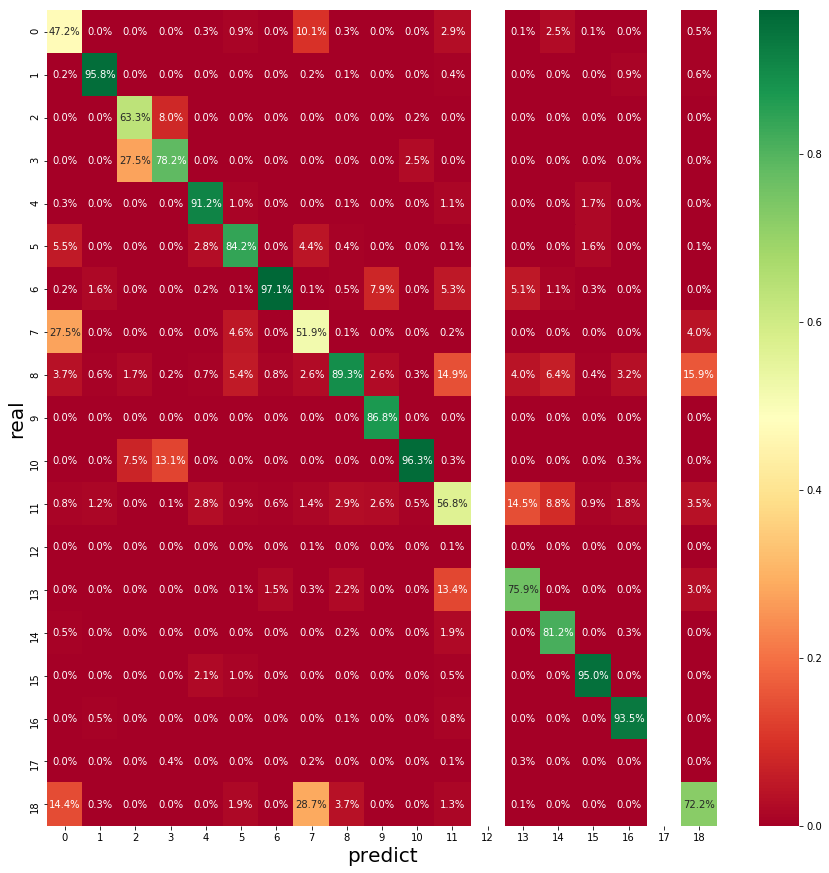

In [24]:
plt.figure(figsize =(15,15))
sns.heatmap(cm_result/np.sum(cm_result),annot = True, cmap ='RdYlGn',fmt='.1%')
plt.ylabel("real",fontsize=20)
plt.xlabel("predict",fontsize=20)
plt.show()

# REAL

In [25]:
lgbm_c.fit(train_X, train_y)

KeyboardInterrupt: 

In [ ]:
y_pred = lgbm_c.predict_proba(test_X)

In [ ]:
submission = pd.DataFrame(data=y_pred, columns=sample_submission_df.columns, index=sample_submission_df.index)
submission.to_csv('./submisson/submission.csv', index=True)